**Exercise 6.4**

MNIST with fully connected networks and grid/random search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers

plt.style.use("seaborn-v0_8")

The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_valid = x_test[8000:]
y_valid = y_test[8000:]
x_test = x_test[:8000]
y_test = y_test[:8000]

# Hint: convert integer RGB values (0-255) to float values (0-1)


In [3]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

In [4]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2)
x_valid = x_valid.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)
print("x_train shape:", x_train.shape)

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a "zero" is encoded as `[1,0,0,0,0,0,0,0,0,0]` and a "one" as `[0,1,0,0,0,0,0,0,0,0]` etc.
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [5]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [6]:
# define model here
nb_nodes = 128 # 32, 64, 256, 512
activation = "relu"
output = 10
drop_rate = 0.35 # Between 0.2 and 0.5

model = tf.keras.models.Sequential([
    layers.Dense(nb_nodes, activation=activation, input_shape=(784,)),
    layers.Dropout(drop_rate), 
    layers.Dense(output), # output
    # softmax activation to transform output into probabilities
    layers.Activation('softmax')])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
model.compile(
    # the recommended loss for a classification task is 'categorical_crossentropy'
    # (see lecture for details)
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.weights.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

# Keras calculates training accuracy and loss during the training and
# with regularization applied, while the validation metrics are calculated
# at the end of each epoch. This callback calculates the training metrics
# the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0)
        logs["train_loss"] = train_loss
        logs["train_acc"] = train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),

    batch_size=784,
    epochs=10,
    callbacks=[
        save_best,
        CalculateMetrics(),
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
    ]
)

Epoch 1/10
 1/77 [..............................] - ETA: 10s - loss: 2.4999 - accuracy: 0.0778

2025-11-17 15:44:16.322427: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


77/77 [==============================] - 1s 12ms/step - loss: 0.8305 - accuracy: 0.7544 - val_loss: 0.2388 - val_accuracy: 0.9370 - train_loss: 0.3536 - train_acc: 0.9043
Epoch 2/10
77/77 [==============================] - 1s 11ms/step - loss: 0.3661 - accuracy: 0.8967 - val_loss: 0.1731 - val_accuracy: 0.9520 - train_loss: 0.2592 - train_acc: 0.9284
Epoch 3/10
77/77 [==============================] - 1s 11ms/step - loss: 0.2893 - accuracy: 0.9184 - val_loss: 0.1439 - val_accuracy: 0.9550 - train_loss: 0.2109 - train_acc: 0.9419
Epoch 4/10
77/77 [==============================] - 1s 11ms/step - loss: 0.2481 - accuracy: 0.9296 - val_loss: 0.1256 - val_accuracy: 0.9635 - train_loss: 0.1795 - train_acc: 0.9500
Epoch 5/10
77/77 [==============================] - 1s 12ms/step - loss: 0.2171 - accuracy: 0.9379 - val_loss: 0.1139 - val_accuracy: 0.9685 - train_loss: 0.1574 - train_acc: 0.9563
Epoch 6/10
77/77 [==============================] - 1s 11ms/step - loss: 0.1962 - accuracy: 0.9450 - 

In [8]:
# load best model
model.load_weights(f"best_model_{model.name}.weights.h5")

# ------------------------
# ---     Plotting     ---
# ------------------------

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)
# add plots below


In [9]:
# evaluate performance

print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    [
        "Train",
        *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Validation",
        *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Test",
        *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=nb_nodes)[1]) * 100,
    ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0985713 |   0.97245  |                2.755  |
| Validation | 0.078314  |   0.974    |                2.6    |
| Test       | 0.122351  |   0.963375 |                3.6625 |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The results for different NN with different number of nodes and # of hidden layers are shown below. For the case where the number of hidden layers was increased, the number of nodes was left constant to the baseline case of 128 nodes.

Model performance :
|            |     Loss |   Accuracy |   Test error rate [%] |
|------------+----------+------------+-----------------------|
| Train      | 0.202712 |   0.942167 |               5.78333 |
| Validation | 0.13691  |   0.958    |               4.2     |
| Test       | 0.223532 |   0.9345   |               6.55    | 32

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.14207   |   0.959867 |               4.01334 |
| Validation | 0.0992002 |   0.973    |               2.7     |
| Test       | 0.159335  |   0.953875 |               4.6125  | 64

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0980704 |   0.972817 |               2.71834 |
| Validation | 0.077308  |   0.978    |               2.2     |
| Test       | 0.123279  |   0.963375 |               3.6625  | 128

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0724355 |   0.980683 |               1.93167 |
| Validation | 0.0697489 |   0.979    |               2.1     |
| Test       | 0.0997855 |   0.970625 |               2.9375  | 256

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.057351  |   0.984533 |               1.54667 |
| Validation | 0.0567257 |   0.9835   |               1.65    |
| Test       | 0.0836929 |   0.9745   |               2.55    | 512

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0564644 |   0.983233 |               1.67667 |
| Validation | 0.0654285 |   0.981    |               1.9     |
| Test       | 0.0885071 |   0.973375 |               2.6625  | 2 layers 128 nodes each

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0336281 |   0.990717 |               0.92833 |
| Validation | 0.0581913 |   0.9835   |               1.65    |
| Test       | 0.0781255 |   0.97475  |               2.525   | 3 layers 128 nodes each

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0252106 |   0.992417 |              0.758332 |
| Validation | 0.0609595 |   0.9845   |              1.55     |
| Test       | 0.0842254 |   0.975875 |              2.4125   | 4 layers 128 nodes each

Model performance :
|            |      Loss |   Accuracy |   Test error rate [%] |
|------------+-----------+------------+-----------------------|
| Train      | 0.0328112 |   0.991    |                0.9    |
| Validation | 0.0610867 |   0.9835   |                1.65   |
| Test       | 0.0792344 |   0.975125 |                2.4875 | 5 layers 128 nodes each


From this results it is seen that the increase of nodes improves the model accuracy terms of train, validation and test data. Whereas the increase of hidden layers does not reflects this improved accuracy as well. As it is seen that a maximum of 97.58% is achieved for 4 layers, rather than for 5. Furthermore, as more hidden layers are added it seems that the NN starts overstimating the data further and further as the model improves the most only against seen data and not against unseen.

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [10]:
# @title
def plot_image(X, ax=None):
    """Plot an image X.

    Args:
        X (2D array): image, grayscale or RGB
        ax (None, optional): Description
    """
    if ax is None:
        ax = plt.gca()

    if (X.ndim == 2) or (X.shape[-1] == 1):
        ax.imshow(X.astype("uint8"), origin="upper", cmap=plt.cm.Greys)
    else:
        ax.imshow(X.astype("uint8"), origin="upper")

    ax.set(xticks=[], yticks=[])


def plot_prediction(Yp, X, y, classes=None, top_n=False):
    """Plot an image along with all or the top_n predictions.

    Args:
        Yp (1D array): predicted probabilities for each class
        X (2D array): image
        y (integer): true class label
        classes (1D array, optional): class names
        top_n (int, optional): number of top predictions to show
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)
    plot_image(X, ax1)

    if top_n:
        n = top_n
        s = np.argsort(Yp)[-top_n:]
    else:
        n = len(Yp)
        s = np.arange(n)[::-1]

    patches = ax2.barh(np.arange(n), Yp[s], align="center")
    ax2.set(xlim=(0, 1), xlabel="Probability", yticks=[])

    for iy, patch in zip(s, patches):
        if iy == y:
            patch.set_facecolor("C1")  # color correct patch

    if classes is None:
        classes = np.arange(0, np.size(Yp))

    for i in range(n):
        ax2.text(0.05, i, classes[s][i], ha="left", va="center")

    plt.show()


def plot_confusion(yp, y, classes=None, fname=None):
    """Plot confusion matrix for given true and predicted class labels

    Args:
        yp (1D array): predicted class labels
        y (1D array): true class labels
        classes (1D array): class names
        fname (str, optional): filename for saving the plot
    """
    if classes is None:
        n = max(max(yp), max(y)) + 1
        classes = np.arange(n)
    else:
        n = len(classes)

    bins = np.linspace(-0.5, n - 0.5, n + 1)
    C = np.histogram2d(y, yp, bins=bins)[0]
    C = C / np.sum(C, axis=0) * 100

    _ = plt.figure(figsize=(8, 8))
    plt.imshow(C, interpolation="nearest", vmin=0, vmax=100, cmap=plt.cm.YlGnBu)
    plt.gca().set_aspect("equal")
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label("Frequency %")
    plt.xlabel("Prediction")
    plt.ylabel("Truth")
    plt.xticks(range(n), classes, rotation="vertical")
    plt.yticks(range(n), classes)
    for x in range(n):
        for y in range(n):
            if np.isnan(C[x, y]):
                continue
            color = "white" if x == y else "black"
            plt.annotate(
                "%.1f" % (C[x, y]), xy=(y, x), color=color, ha="center", va="center"
            )

    plt.show()

63/63 [==============================] - 0s 393us/step


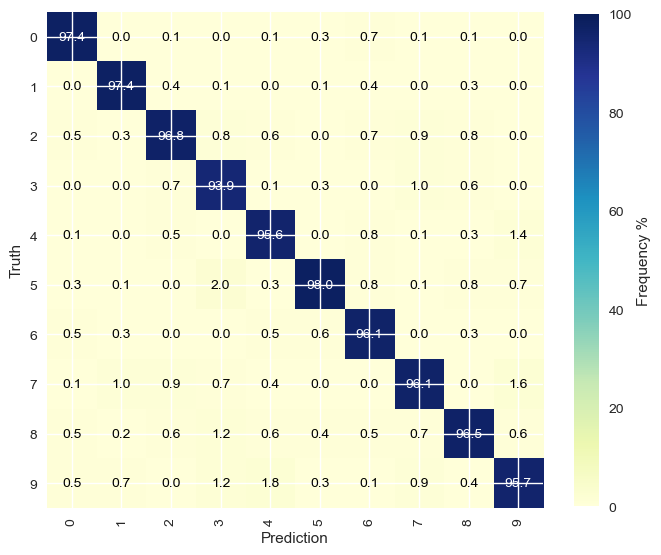

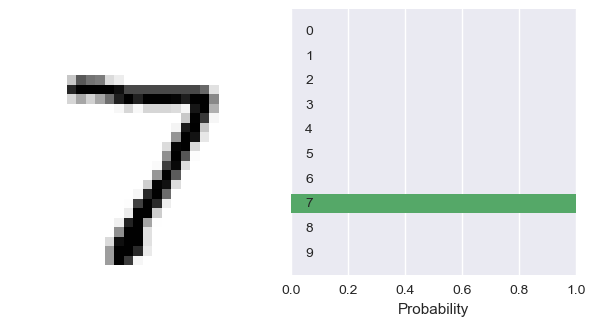

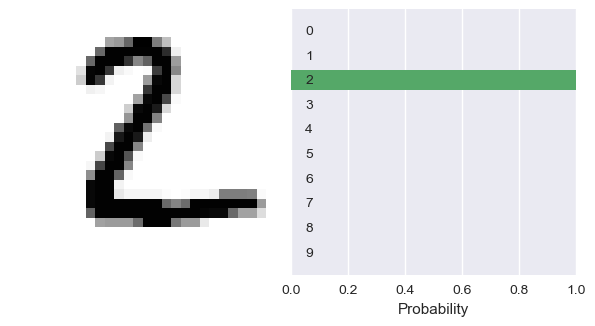

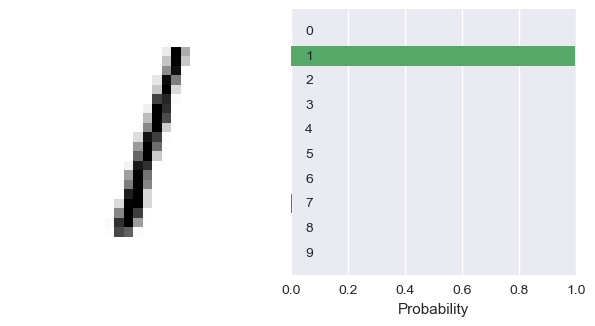

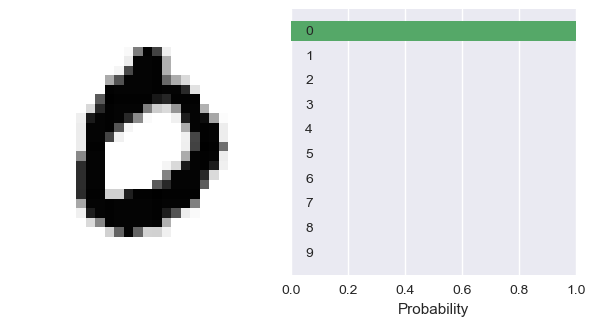

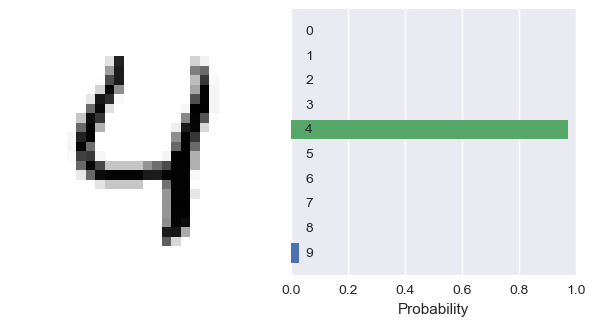

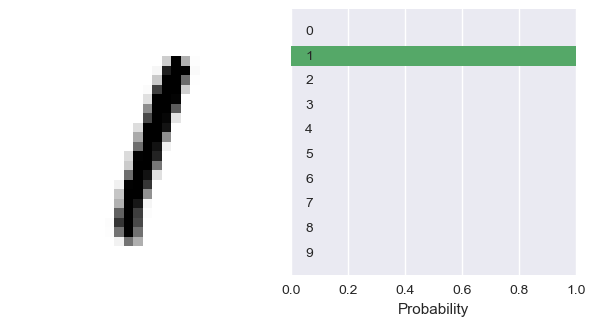

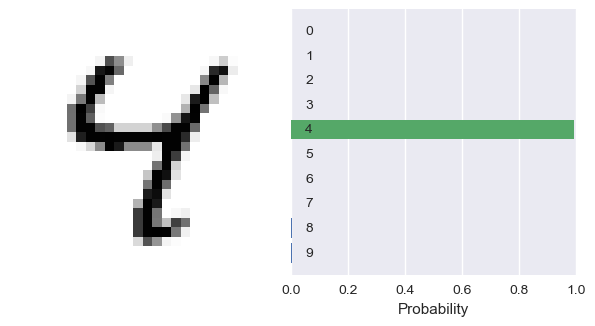

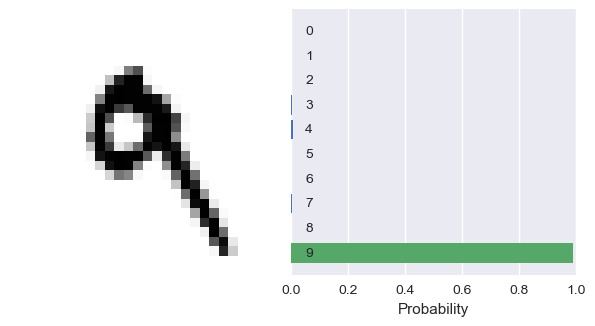

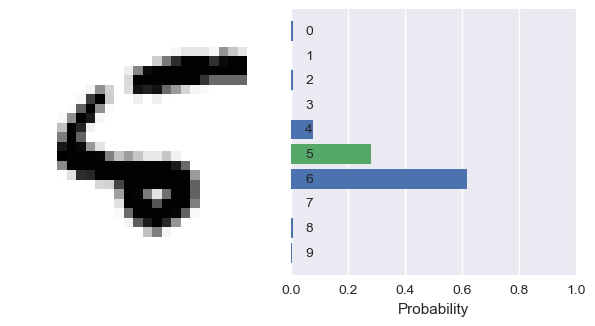

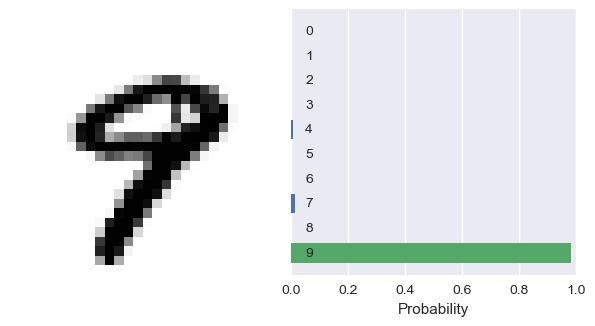

In [11]:
# plot a few examples, loop over test dataset:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])


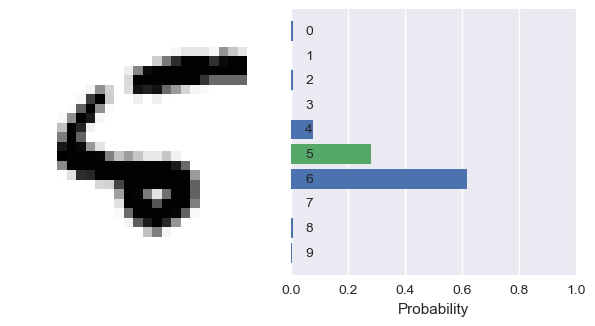

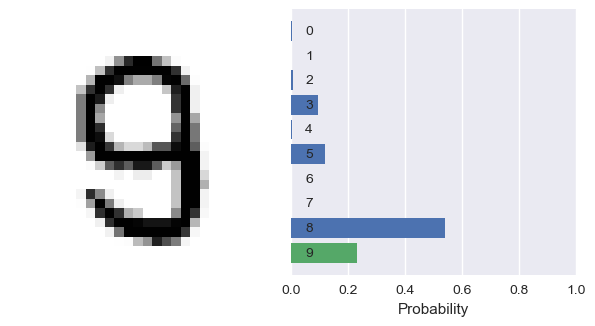

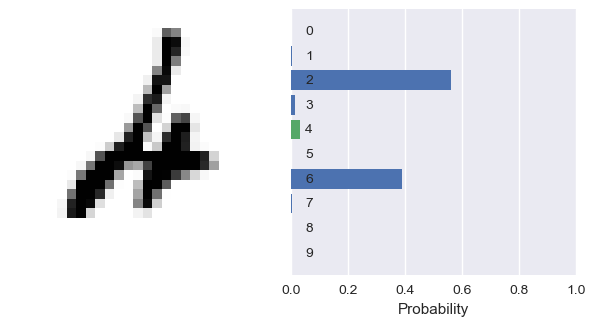

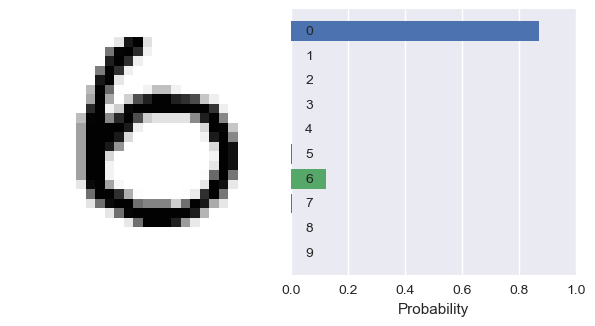

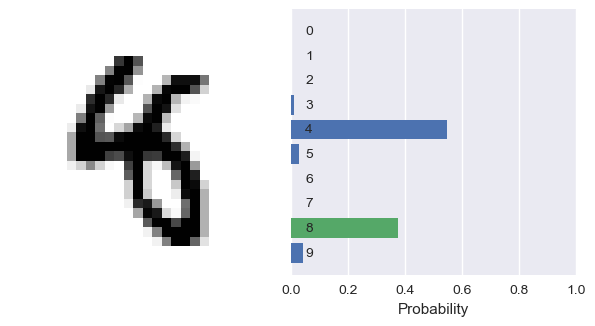

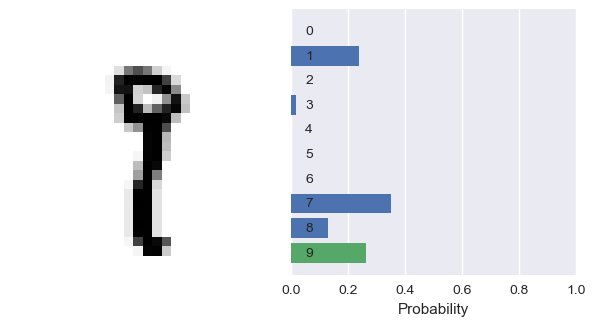

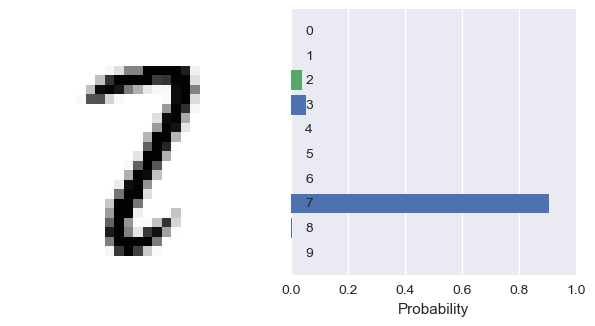

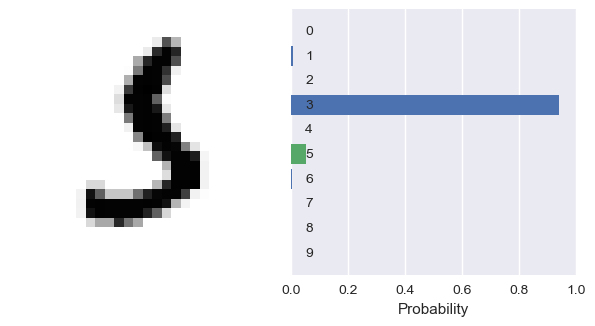

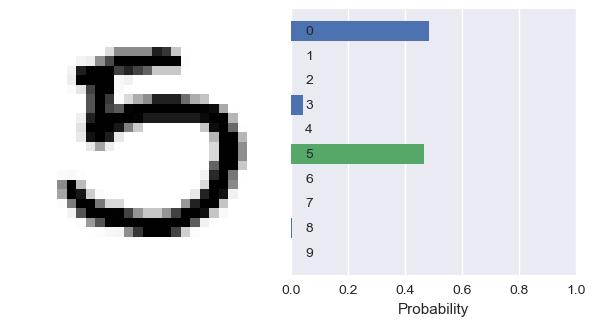

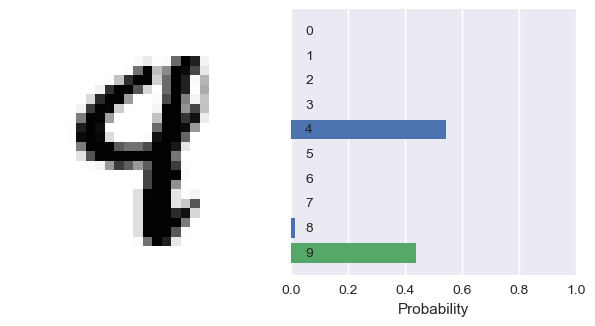

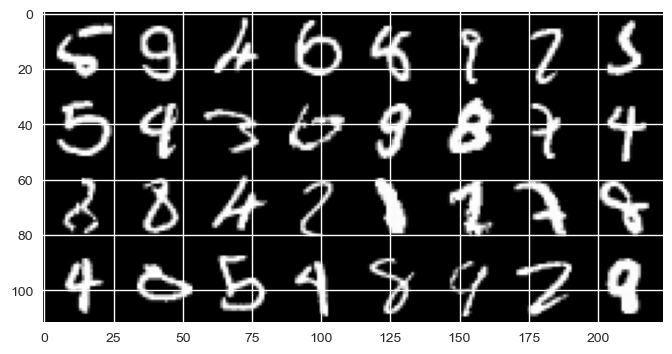

In [12]:
# now plot a few examples that were misclassified

indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# or plot 32 of them in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap="gray")


**Grid search**

Let's search the two hyperparameters dropout and number of nodes. You can start from the template below.



In [13]:
# Experiment with diﬀerent network structures (diﬀerent number of neurons and hidden layers)
# to see how the performance increases. Report your results.
dropout_values = [0.2, 0.22, 0.24, 0.26, 0.28, 0.3]
n_neurons_values = [10, 20, 50, 100, 200, 500]
results_gridsearch = np.zeros((len(dropout_values), len(n_neurons_values), 2))
for iDrop, drop in enumerate(dropout_values):
  for iN, n_neurons in enumerate(n_neurons_values):
    model = tf.keras.models.Sequential([
        layers.Dense(n_neurons, activation="relu", input_shape=(784,)),
        layers.Dropout(drop),
        layers.Dense(10),
        # softmax actication to transform output into probabilities
        layers.Activation('softmax')])

    model.compile(
        # the recommended loss for a classification task is 'categorical_crossentropy'
        # (see lecture for details)
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
        metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

    results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=784,
        epochs=10,
        verbose=0
        )
    t = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)
    results_gridsearch[iDrop, iN] = t
    print(f"dropout = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


dropout = 0.20, 10 neurons -> accuracy 0.898, error rate = 10.2%
dropout = 0.20, 20 neurons -> accuracy 0.924, error rate = 7.6%
dropout = 0.20, 50 neurons -> accuracy 0.952, error rate = 4.8%
dropout = 0.20, 100 neurons -> accuracy 0.962, error rate = 3.8%
dropout = 0.20, 200 neurons -> accuracy 0.970, error rate = 3.0%
dropout = 0.20, 500 neurons -> accuracy 0.976, error rate = 2.4%
dropout = 0.22, 10 neurons -> accuracy 0.897, error rate = 10.3%
dropout = 0.22, 20 neurons -> accuracy 0.926, error rate = 7.4%
dropout = 0.22, 50 neurons -> accuracy 0.950, error rate = 5.0%
dropout = 0.22, 100 neurons -> accuracy 0.963, error rate = 3.7%
dropout = 0.22, 200 neurons -> accuracy 0.971, error rate = 2.9%
dropout = 0.22, 500 neurons -> accuracy 0.976, error rate = 2.4%
dropout = 0.24, 10 neurons -> accuracy 0.894, error rate = 10.6%
dropout = 0.24, 20 neurons -> accuracy 0.921, error rate = 7.9%
dropout = 0.24, 50 neurons -> accuracy 0.948, error rate = 5.2%
dropout = 0.24, 100 neurons -> 

It was seen that a NN with more neurons increases it's accuracy and with lower percentage of dropout values increased as well.
Dropouts between 0.2 to 0.5 in increments of 0.1 where studied and values n_neurons between 10 to 50 intervals where studied.
After several tunning it was found that the best confguration is a dropout of 0.28 and 500 neurons as an accuracy of 97.8% was reached

**Random search**

Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time. You can start from the template below.




In [14]:
N = 20 # number of trials
search = {
    'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
    'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
    'learn_rate': np.random.choice([-5,-4, -3, -2, -1],N),
    'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
    'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
    'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(search['batch_size'][i], activation = search['activation'][i], input_shape=(784,)),
                      tf.keras.layers.Dropout(search['dropout'][i]),
                      tf.keras.layers.Dense(10, activation='softmax')])
  model.compile(loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1*10**int(search['learn_rate'][i])), metrics=['accuracy'])
  results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=784,
        epochs=10,
        verbose=0
      )
  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")


iteration 0:
	batch_size: 16
	num_neurons: 512
	learn_rate: -4
	activation: elu
	dropout: 0.1
	val_acc: 0.8412500023841858
	-> accuracy 0.841, error rate = 15.9%
iteration 1:
	batch_size: 64
	num_neurons: 512
	learn_rate: -2
	activation: relu
	dropout: 0.0
	val_acc: 0.9737499952316284
	-> accuracy 0.974, error rate = 2.6%
iteration 2:
	batch_size: 64
	num_neurons: 32
	learn_rate: -3
	activation: relu
	dropout: 0.3
	val_acc: 0.9526249766349792
	-> accuracy 0.953, error rate = 4.7%
iteration 3:
	batch_size: 16
	num_neurons: 8
	learn_rate: -2
	activation: tanh
	dropout: 0.2
	val_acc: 0.9331250190734863
	-> accuracy 0.933, error rate = 6.7%
iteration 4:
	batch_size: 128
	num_neurons: 512
	learn_rate: -5
	activation: relu
	dropout: 0.2
	val_acc: 0.7021250128746033
	-> accuracy 0.702, error rate = 29.8%
iteration 5:
	batch_size: 64
	num_neurons: 8
	learn_rate: -4
	activation: tanh
	dropout: 0.0
	val_acc: 0.8927500247955322
	-> accuracy 0.893, error rate = 10.7%
iteration 6:
	batch_size: 256


In this case, the best iteration was iteration 1, as it has the best accuracy 0.974